In [18]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data(file_path):
    if file_path.endswith('.csv'):
        return pd.read_csv(file_path)
    elif file_path.endswith('.pkl'):
        return pd.read_pickle(file_path)
    else:
        raise ValueError("Unsupported file format")



In [3]:

data = load_data("processed_data.csv")

In [4]:
label_col = 'TX_FRAUD'
y = data[label_col]
X = data.drop(columns=[label_col])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [6]:
### Cell 4: Handle Imbalance (Using Class Weights & SMOTE)
# Compute class weights
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Apply SMOTE if needed (Optional)
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))


In [8]:
base_models = [('random_forest', rf), ('xgboost', xgb)]
meta_model = LogisticRegression()

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)


In [9]:
stacking_clf.fit(X_train_sm, y_train_sm)


StackingClassifier(cv=5,
                   estimators=[('random_forest',
                                RandomForestClassifier(class_weight='balanced',
                                                       random_state=42)),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=N...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression())

In [10]:
y_pred = stacking_clf.predict(X_test)
y_prob = stacking_clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1914
           1       1.00      1.00      1.00        16

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930

ROC AUC Score: 1.0


In [11]:
joblib.dump(stacking_clf, 'stacked_model.pkl')

['stacked_model.pkl']

In [12]:
loaded_model = joblib.load('stacked_model.pkl')
def predict_fraud(new_data):
    return loaded_model.predict(new_data)


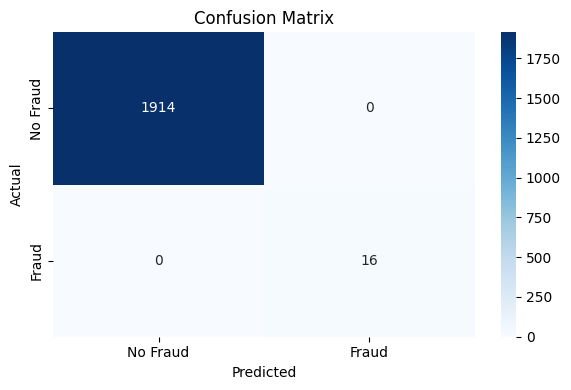

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1914
           1       1.00      1.00      1.00        16

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930



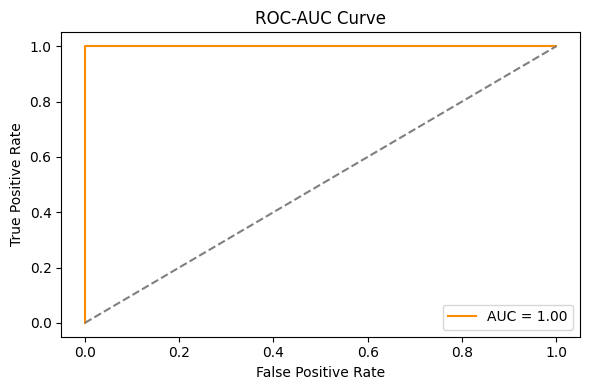

In [19]:


# Load model & test data
stacked_model = joblib.load("stacked_model.pkl")
X_test = joblib.load("X_test.pkl")
y_test = joblib.load("y_test.pkl")

# Check required features by the model
model_features = stacked_model.feature_names_in_

# Align X_test with model's features (avoid KeyErrors)
for col in model_features:
    if col not in X_test.columns:
        X_test[col] = 0  # Fill missing columns if needed

X_test = X_test[model_features]

# Convert all object columns to numeric if needed
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

X_test.fillna(0, inplace=True)  # In case any NaNs were created

# Predictions
y_pred = stacked_model.predict(X_test)
y_pred_proba = stacked_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification Report
print(" Classification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.tight_layout()
plt.show()



